In [2]:
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
from utils.CopulaHelpers import *
from utils.Viterbi import Viterbi, compute_log_likelihood

In [3]:
DATA_DIR="data/"
HIDDEN_STATES = 4

In [4]:
data = pd.read_csv(f"{DATA_DIR}hulls_df_matchday2_reduced.csv")
data = data.dropna()
data["HomeHull"]=data["HomeHull"]/100
data["AwayHull"]=data["AwayHull"]/100
events=pd.read_csv(f"{DATA_DIR}matchday2_events.csv")
goals_info=events[events["Subtype"].isin(["ON TARGET-GOAL","HEAD-ON TARGET-GOAL","WOODWORK-GOAL"])]
home_goals=goals_info[goals_info["Team"]=="Home"]
away_goals=goals_info[goals_info["Team"]=="Away"]
shots_info=events[events["Type"]=="SHOT"]
home_shot=shots_info[shots_info["Team"]=="Home"]
away_shot=shots_info[shots_info["Team"]=="Away"]

In [5]:
sequence_XY = torch.tensor(data[["HomeHull","AwayHull"]].values)
sequence_XY.shape

torch.Size([1970, 2])

In [6]:
posterior=torch.load(f"parameters/CopulaHMM_matchday2_{HIDDEN_STATES}states.pt")

In [7]:
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]
initial_state_probs=torch.ones(HIDDEN_STATES)/HIDDEN_STATES

In [8]:
posterior

{'probs_x': tensor([[0.9159, 0.0482, 0.0250, 0.0108],
         [0.0750, 0.8209, 0.0499, 0.0542],
         [0.0236, 0.0156, 0.9410, 0.0198],
         [0.0299, 0.0432, 0.0856, 0.8413]], requires_grad=True),
 'probs_alpha1': tensor([ 8.7339, 13.2100, 22.3383, 12.2970], requires_grad=True),
 'probs_beta1': tensor([1.5902, 1.5496, 2.2194, 0.9870], requires_grad=True),
 'probs_alpha2': tensor([14.0464, 12.2628, 11.5161, 15.6416], requires_grad=True),
 'probs_beta2': tensor([1.4720, 0.9068, 1.8164, 1.5019], requires_grad=True),
 'theta': tensor([0.9842, 2.3156, 0.3383, 2.3270], requires_grad=True)}

In [9]:
MLS=Viterbi(sequence_XY, initial_states_prob=initial_state_probs, transition_matrix=transition_matrix,
            shape_params1=shape_params1,rate_params1=rate_params1,shape_params2=shape_params2,rate_params2=rate_params2,theta=theta)

In [10]:
loglik = compute_log_likelihood(sequence_XY, initial_state_probs, transition_matrix, shape_params1, rate_params1, shape_params2, rate_params2, theta)
print(f"Loglikelihood: {loglik}")

Loglikelihood: -8902.3544921875


Add to the dataframe the most likely states

In [9]:
data["HomeMLS"]=MLS.numpy()
data["AwayMLS"]=MLS.numpy()

In [10]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue',
    4: 'purple'
}
colors = data['AwayMLS'].map(class_colors)

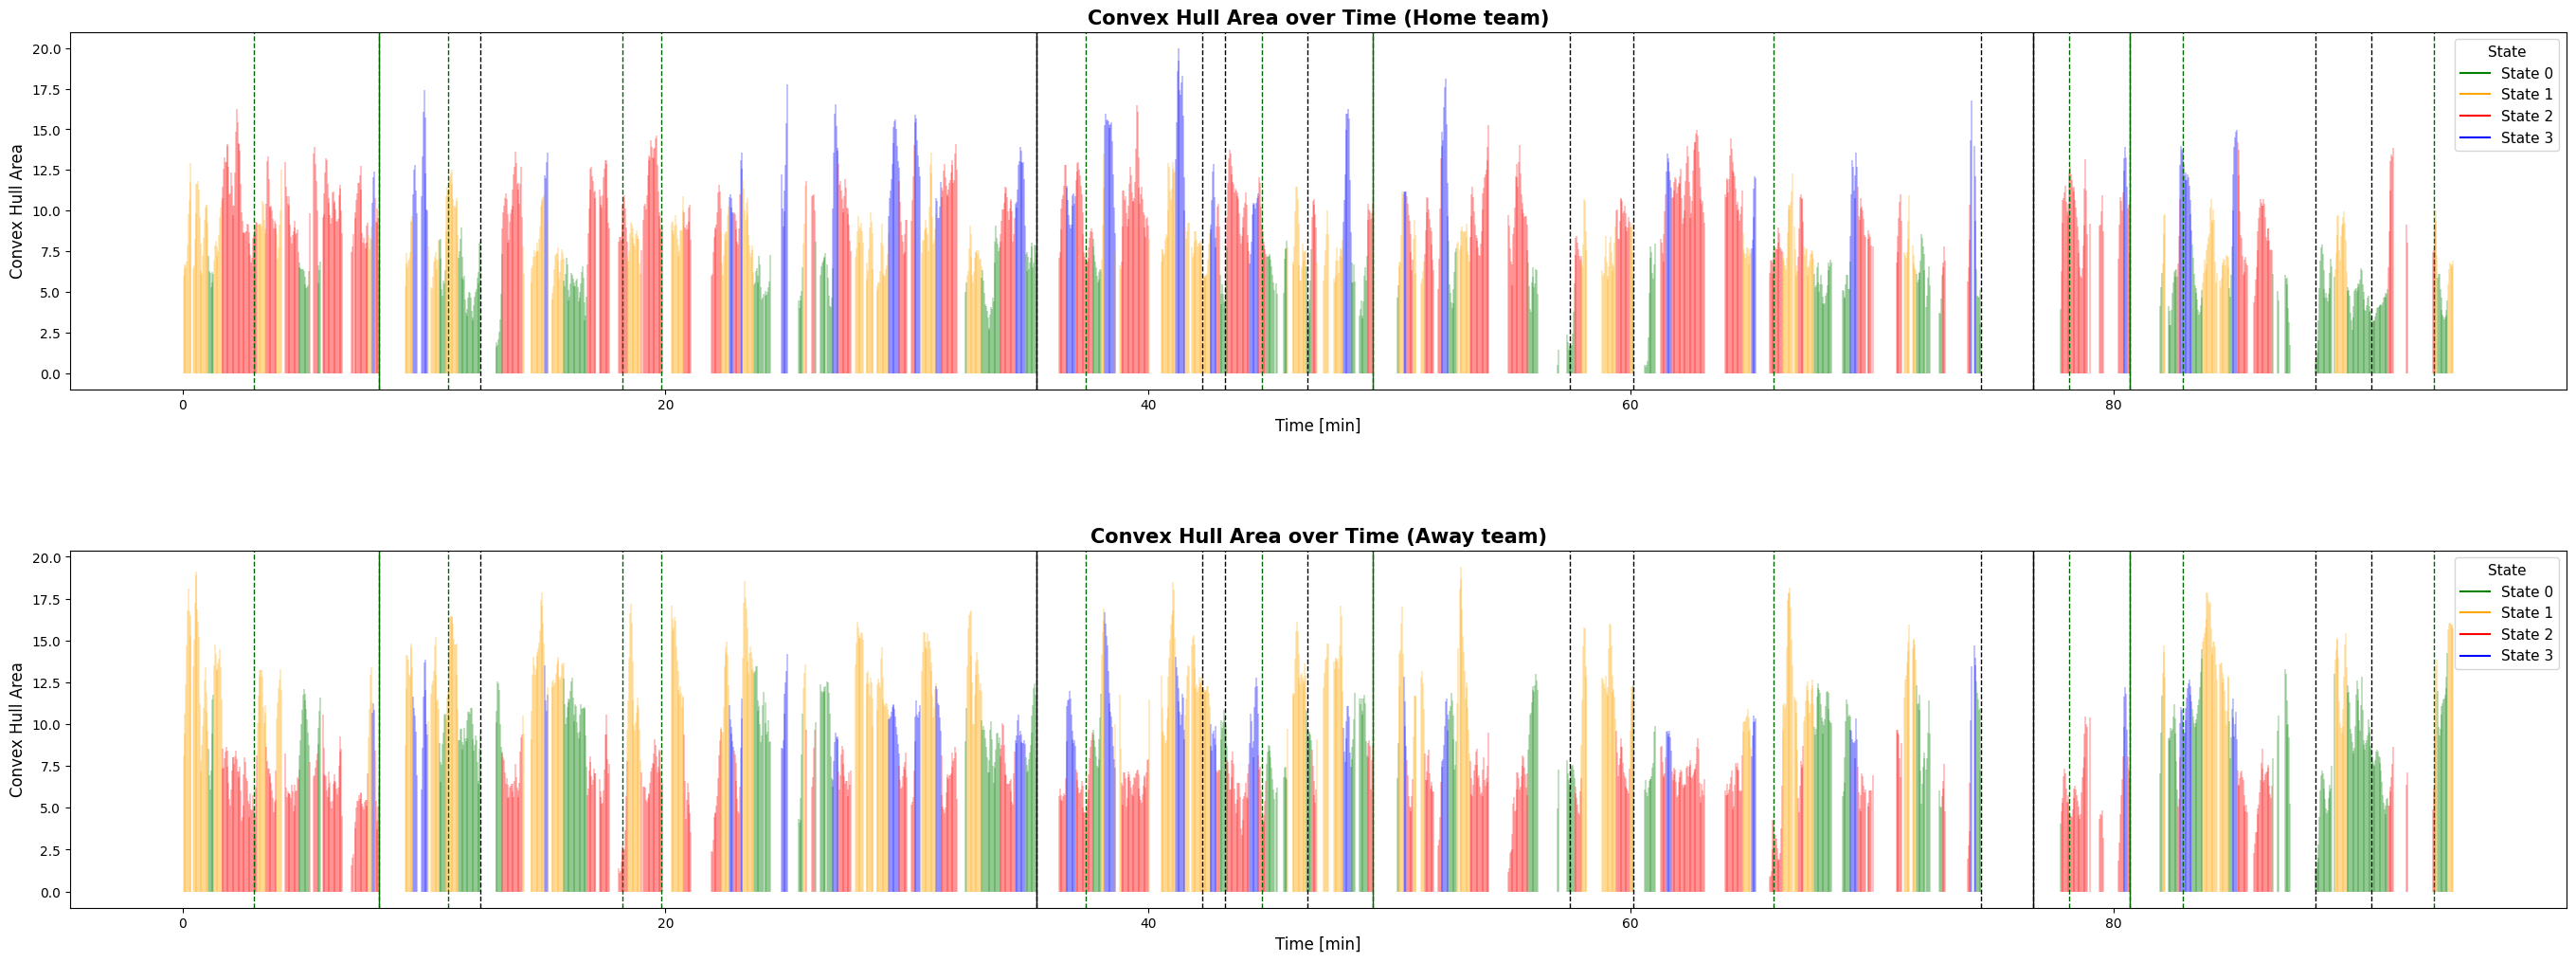

In [11]:

fig, axs = plt.subplots(2, 1, figsize=(34, 12))
# Home team's convex hull area
axs[0].vlines(data["Time [s]"]/60, ymin=0, ymax=data["HomeHull"], color=colors, linewidth=0.35)
axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
# add legend
for i, state in enumerate([0,1,2,3]):
    axs[0].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[0].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# Away team's convex hull area
axs[1].vlines(data["Time [s]"]/60, ymin=0, ymax=data["AwayHull"],color=colors, linewidth=0.35)
axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
for i, state in enumerate([0,1,2,3]):
    axs[1].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[1].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');
# add vertical lines for home shots
for t1,t2 in zip(home_shot["Start Time [s]"]/60,home_shot["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=1)
for t1,t2 in zip(away_shot["Start Time [s]"]/60,away_shot["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=1)
# # add vertical lines for home goals
for t1,t2 in zip(home_goals["Start Time [s]"]/60,home_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='-', linewidth=1)
# add vertical lines for away goals
for t1,t2 in zip(away_goals["Start Time [s]"]/60,away_goals["End Time [s]"]/60):
    axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=1) 
    axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='-', linewidth=1)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
#plt.savefig("../plots/BivariateHMM_MostLikelySeq_matchday2_every2.png",dpi=350, bbox_inches='tight')

Text(0.5, 1.0, 'Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)')

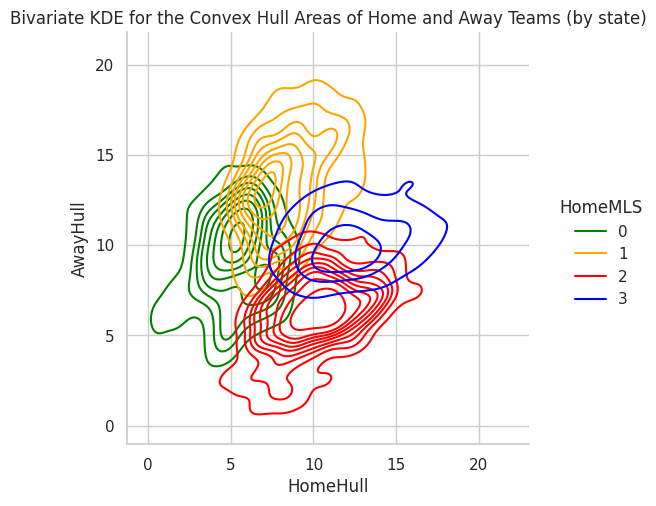

In [12]:
sns.set_theme(style="whitegrid")
sns.displot(data, x="HomeHull", y="AwayHull", hue="HomeMLS", kind="kde", palette=class_colors)
plt.title("Bivariate KDE for the Convex Hull Areas of Home and Away Teams (by state)")
#plt.savefig("../plots/BivariateHMM_Distribution_matchday2_every2_5STATES.png",dpi=350, bbox_inches='tight')

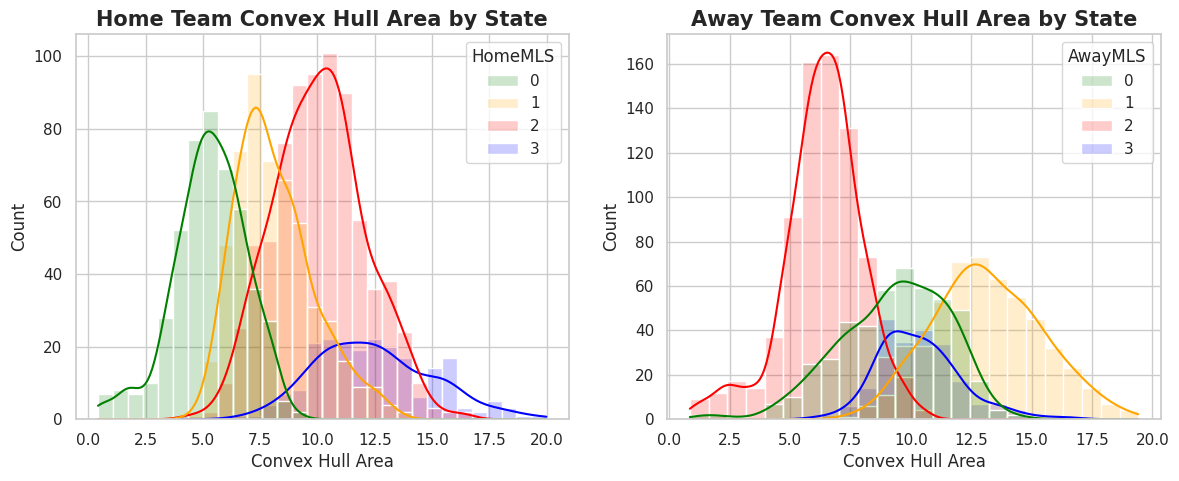

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # Adjusted figsize for better visualization

sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors, alpha=0.2, ax=ax[0])
ax[0].set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal')
ax[0].set_ylabel("Count", fontsize=12, fontweight='normal')
ax[0].set_title("Home Team Convex Hull Area by State", fontsize=15, fontweight='bold')

sns.histplot(data, x="AwayHull", hue="AwayMLS", kde=True, palette=class_colors, alpha=0.2, ax=ax[1])
ax[1].set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal')
ax[1].set_ylabel("Count", fontsize=12, fontweight='normal')
ax[1].set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold')

plt.subplots_adjust(hspace=0.45)
plt.show()
#plt.savefig("../plots/BivariateHMM_Histograms_every2.png",dpi=350, bbox_inches='tight')